### Hill-Climbing Modularity Maximization

Demonstrate [Newman's hill-climbing algorithm](https://www.pnas.org/doi/pdf/10.1073/pnas.0601602103) from Newman, Mark EJ. "Modularity and community structure in networks." _Proceedings of the national academy of sciences_, 103.23 (2006): 8577-8582.

Create the visualization functions

In [1]:
############
## Cell 1 ##
############

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import networkx as nx
import numpy as np
from typing import Hashable, Tuple, Set

def get_NCM_Figure3_14() -> Tuple[nx.Graph, dict[Hashable, Tuple[float, float]]]:
    """
        Figure 3.14 from the book Networks, Crowds, and Markets is a useful
        example graph. This function returns this figure as a networkx Graph
        and a position dictionary for the neato layout
    """
    G: nx.Graph = nx.Graph()
    G.add_nodes_from(range(0,14))
    G.add_edges_from([(0,1),(0,2),(1,2),(3,4),(3,5),(4,5),(8,9),(8,10),(9,10),(11,12),(11,13),(12,13),(2,6),(5,6),(7,8),(7,11),(6,7)])
    pos: dict[Hashable, Tuple[float, float]] = nx.nx_pydot.graphviz_layout(G,prog='neato')
    return G, pos

def draw_edge_by_type(G: nx.Graph, 
                      pos: dict[Hashable, Tuple[float, float]], 
                      edge: Tuple[Hashable, Hashable], 
                      partition: Tuple[Set, ...]
                      ) -> None:
    """
        Draw edges between nodes in different partitions using dashed lines.
        Draw edges between nodes within the same partition using solid lines.
    """
    edge_style = 'dashed'
    for part in partition:
        if edge[0] in part and edge[1] in part:
            edge_style = 'solid'
            break
    nx.draw_networkx_edges(G, pos, edgelist=[edge], style = edge_style)

def show_partitions(G: nx.Graph,
                    partition: Tuple[Set, ...], 
                    pos: dict[Hashable, Tuple[float, float]] | None = None,
                    title = ""
                    ) -> None:
    """ 
        Show the networkx graph with colors and edges indicating properties
        of the partition

        Edges:
        • Dashed lines indicate edges between nodes in different partitions
        • Solid lines indicate edges between nodes in the same partition

        Nodes:
        • All nodes in the same partition get mapped to the same color
        • When there are more partitions than ther are in the color pallette, repeat colors
    """
    #color_list = ['c','m','y','g','r']
    color_list: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'lightpink', 'lightgray', 'linen']
    plt.clf()
    ax: Axes = plt.gca()
    if pos is None: 
        pos = nx.spring_layout(G, seed = 0)
    for i in range(len(partition)):
        nx.draw_networkx_nodes(partition[i],pos,node_color=color_list[i%len(color_list)], alpha = 0.8)
    for edge in G.edges:
        draw_edge_by_type(G, pos, edge, partition)
    nx.draw_networkx_labels(G,pos)
    if len(G.edges) == 0:
        mod = 0
    else:
        mod = nx.algorithms.community.quality.modularity(G,partition)
    title = title + " Modularity = " + str(np.round(mod,2))

    ax.set_title(title)
    ax.set_axis_off()

Instantiate an example graph.

In [2]:
############
## Cell 2 ##
############
G, pos = get_NCM_Figure3_14() # network to be split

Consider only binary partitions. Call each partition a "shore". We need three utility functions:
- Initialize the algorithm by randomly assign nodes to a "shore" 
- Move a node from one shore to another
- Find the node that provides the greatest increase in modularity if swapped.

In [3]:
############
## Cell 3 ##
############

import random
from copy import deepcopy
def split_into_random_shores(G: nx.Graph) -> list[Set, Set]:
    """ 
        The Newman algorithm for random and greedy hill-climbing 
        starts with nodes assigned randomly two two shores.
    """
    shore_size: int = len(G.nodes)/2
    shore1: set[Hashable] = set(G.nodes)
    shore2: set[Hashable] = set()
    while len(shore2) < shore_size:
        node: Hashable = random.choice(list(shore1))
        shore2.add(node)
        shore1.remove(node)
    return [shore1, shore2]

def swap_shores(partition, node):
    """ 
        Swapping shores means moving a node from one
        partition to another.
    """
    shore1: Set = deepcopy(partition[0])
    shore2: Set = deepcopy(partition[1])
    if node in partition[0]:
        shore1.remove(node)
        shore2.add(node)
    else:
        shore2.remove(node)
        shore1.add(node)
    return [shore1, shore2]

def find_best_node_to_swap(G: nx.Graph,
                           partition: Tuple[Set, Set],
                           already_swapped: Set
                           ) -> Hashable | None:
    best_mod: float = -np.inf
    # Node that produces the highest modularity increase if it swaps shores
    best_node_to_swap: Hashable | None = None  
    # Track nodes that have already been swapped
    for node in set(G.nodes()) - already_swapped:
        possible_partition = swap_shores(partition, node)
        mod = nx.algorithms.community.quality.modularity(G,possible_partition)
        if mod > best_mod:
            best_mod = mod
            best_node_to_swap = node
    return best_node_to_swap


[{0, 5, 8, 9, 10, 12, 13}, {1, 2, 3, 4, 6, 7, 11}]


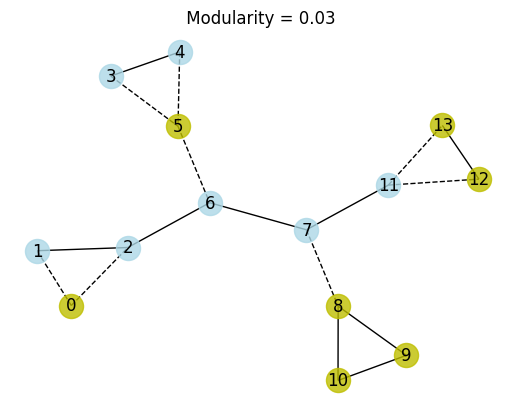

In [4]:
############
## Cell 4 ##
############
partition = split_into_random_shores(G)
print(partition)
show_partitions(G, partition, pos)

[{0, 8, 9, 10, 12, 13}, {1, 2, 3, 4, 5, 6, 7, 11}]


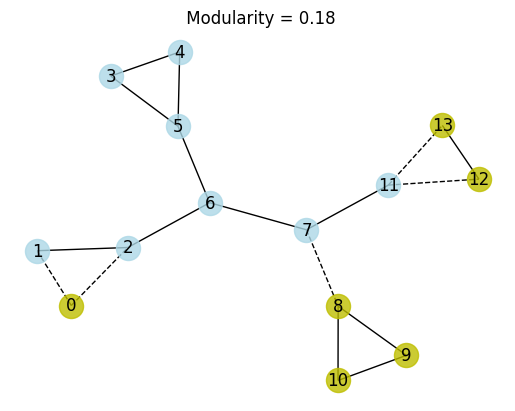

In [5]:
############
## Cell 5 ##
############

already_swapped: set[Hashable] = set()
best_node_to_swap: Hashable| None = find_best_node_to_swap(G, partition, already_swapped)
partition = swap_shores(partition, best_node_to_swap)
already_swapped.add(best_node_to_swap)
print(partition)
show_partitions(G,partition, pos)


Repeat

[{0, 8, 9, 10, 11, 12, 13}, {1, 2, 3, 4, 5, 6, 7}]


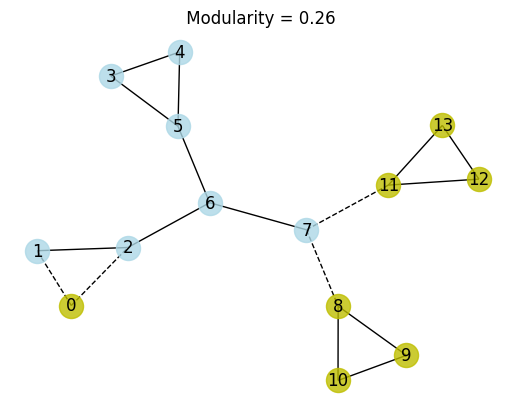

In [6]:
############
## Cell 6 ##
############

best_node_to_swap = find_best_node_to_swap(G, partition, already_swapped)
partition = swap_shores(partition, best_node_to_swap)
already_swapped.add(best_node_to_swap)
show_partitions(G,partition, pos)
print(partition)

Repeat until Q stops increasing

[{8, 9, 10, 11, 12, 13}, {0, 1, 2, 3, 4, 5, 6, 7}]


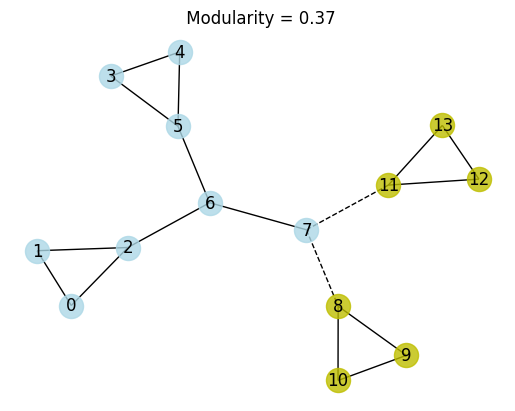

In [7]:
############
## Cell 7 ##
############

best_node_to_swap = find_best_node_to_swap(G, partition, already_swapped)
partition = swap_shores(partition, best_node_to_swap)
already_swapped.add(best_node_to_swap)
show_partitions(G,partition, pos)
print(partition)

[{7, 8, 9, 10, 11, 12, 13}, {0, 1, 2, 3, 4, 5, 6}]


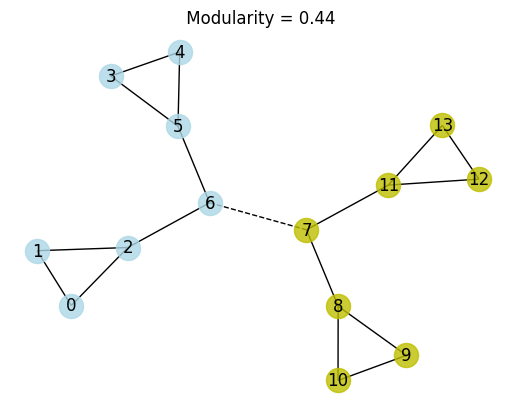

In [8]:
############
## Cell 8 ##
############

best_node_to_swap = find_best_node_to_swap(G, partition, already_swapped)
partition = swap_shores(partition, best_node_to_swap)
already_swapped.add(best_node_to_swap)
show_partitions(G,partition, pos)
print(partition)

[{6, 7, 8, 9, 10, 11, 12, 13}, {0, 1, 2, 3, 4, 5}]


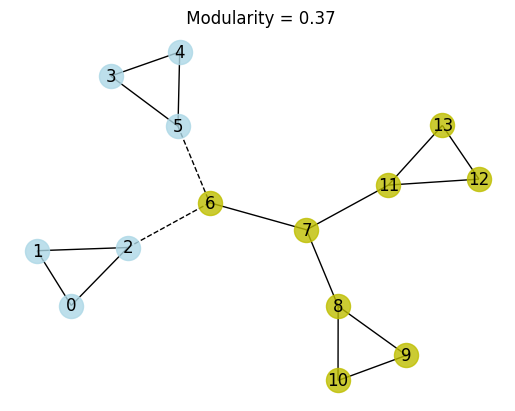

In [9]:
############
## Cell 9 ##
############

best_node_to_swap = find_best_node_to_swap(G, partition, already_swapped)
partition = swap_shores(partition, best_node_to_swap)
already_swapped.add(best_node_to_swap)
show_partitions(G,partition, pos)
print(partition)

[{6, 7, 8, 10, 11, 12, 13}, {0, 1, 2, 3, 4, 5, 9}]


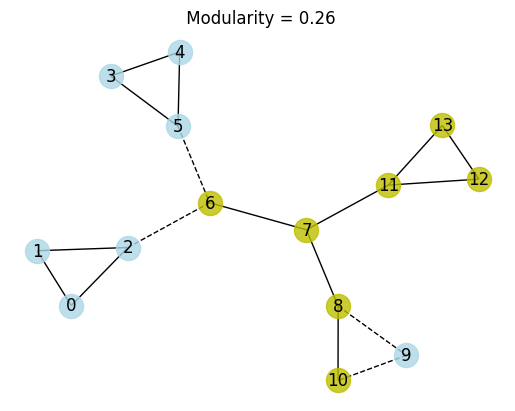

In [10]:
#############
## Cell 10 ##
#############

best_node_to_swap = find_best_node_to_swap(G, partition, already_swapped)
partition = swap_shores(partition, best_node_to_swap)
already_swapped.add(best_node_to_swap)
show_partitions(G,partition, pos)
print(partition)

---

Let's pull the pieces together into a function that executes each step until modularity stops increasing. We can detect when modularity stops increasing by checking to see if the best node to swap has `None` type. 

In [11]:
#############
## Cell 11 ##
#############

import time
from IPython import display

def Newman_hill_climbing(G: nx.Graph
                         ) -> Tuple[Tuple[Set, Set], dict[Hashable, Tuple[float, float]]]:
    """ 
        Implement Newman's hill climbing algorithm for estimating
        the partition that maximizes modularity.

        Returns:
            The best partition found
            and the position of the graph
    """
    # Get positions for plot
    pos: dict[Hashable, Tuple[float, float]] = nx.nx_pydot.graphviz_layout(G,prog='neato')

    # Initialize
    partition: Tuple[Set, ...] = split_into_random_shores(G)
    already_swapped: set[Hashable] = set()
    best_partition: Tuple[Set, ...] = deepcopy(partition)
    best_modularity: float = nx.community.modularity(G, partition)
    
    # Plot 
    delay: float = 0.05
    show_partitions(G, partition, pos)
    

    best_node_to_swap: Hashable| None = find_best_node_to_swap(G, partition, already_swapped)
    while best_node_to_swap is not None:
        partition = swap_shores(partition, best_node_to_swap)
        already_swapped.add(best_node_to_swap)
        
        display.clear_output(wait=True)
        show_partitions(G, partition, pos)
        display.display(plt.gcf())
        time.sleep(delay)
        

        if nx.community.modularity(G, partition) >= best_modularity:
            best_modularity = nx.community.modularity(G, partition)
            best_partition = deepcopy(partition)
        else:
            display.clear_output(wait=True)
            show_partitions(G, best_partition, pos)
            display.display(plt.gcf())
            time.sleep(delay)
            display.clear_output(wait=True)
            return best_partition, pos   # Stop when modularity starts going down

        best_node_to_swap: Hashable| None = find_best_node_to_swap(G, partition, already_swapped)

    return best_partition, pos

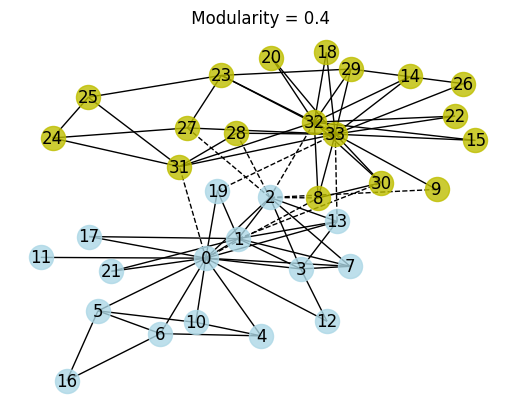

In [12]:
#############
## Cell 12 ##
#############
 
G: nx.Graph = nx.karate_club_graph()
best_partition, pos = Newman_hill_climbing(G)

### Problem with the Algorithm

Run the program multiple times. Each time you run it you'll see a different partition. Why? How do you address this problem?

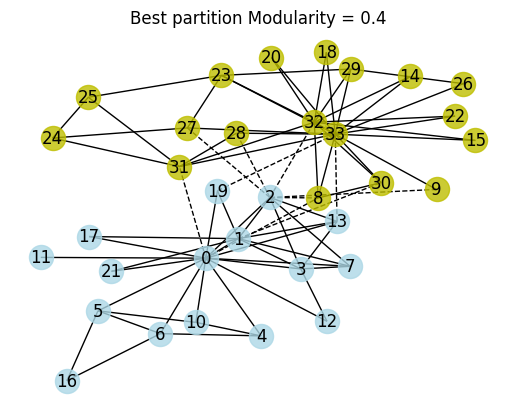

In [13]:
show_partitions(G, best_partition, pos, title = "Best partition")